In [5]:
# Imports for JupyterLite
%pip install -q ipywidgets

In [6]:
import pandas as pd
import os
from fastai.tabular.all import *
import matplotlib.pyplot as plt
import ipywidgets as widgets
import concurrent.futures
import urllib.request

# Adjust this based on data availibility
# The quality of predictions decline rapidly after Oct 2023 so let's zoom on that for now
# FIRST_DAY = pd.Timestamp("2023-10-01")
FIRST_DAY = pd.Timestamp("2016-01-01")

# When the data analysis should stop
# The quality of predictions decline rapidly after Oct 2023 so let's zoom on that for now
LAST_DAY = pd.Timestamp("2024-04-10")

def filter_known_range(df):
  return df[(df['datetime'] >= FIRST_DAY) & (df['datetime'] < LAST_DAY)]

In [3]:
def get_csv(url, local_filename):
    if not os.path.exists(local_filename):
        print(f"{local_filename} not found locally. Downloading and reading from URL...")
        df = pd.read_csv(url)
        df.to_csv(local_filename, index=False)  # Save the downloaded file locally
    else:
        print(f"Reading {local_filename} from local storage...")
        df = pd.read_csv(local_filename)
    return df

In [26]:
# MONTREAL/PIERRE ELLIOTT TRUDEAU INTL QUEBEC
# This station has precipitation but doesn't have a categorical value of weather (e.g cloudy, rain, etc)
station_id = "30165"

years = range(FIRST_DAY.year, LAST_DAY.year + 1)
months = range(1, 13)

dates = [(month, year) for year in years for month in months]
urls = list(map(lambda xy: f"https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={station_id}&Year={xy[1]}&Month={xy[0]}&Day=1&timeframe=1&submit=Download+Data", dates))

def get_weather_csv(url):
    filename = url.split('&Year=')[1].split('&Month=')[0] + '-' + url.split('&Month=')[1].split('&Day=')[0] + '.csv'
    filepath = f'./weather_{filename}'
    try:
        # Create the downloads directory if it doesn't exist
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        # Download and save the file
        with urllib.request.urlopen(url, timeout=30) as response, open(filepath, 'wb') as out_file:
            out_file.write(response.read())
        return filepath
    except Exception as e:
        print(f"Failed to download {url}: {str(e)}")
        return None

# Use a ThreadPoolExecutor to manage concurrent downloads
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # Start the load operations and mark each future with its URL
    future_to_url = {executor.submit(get_weather_csv, url): url for url in urls}
    for future in concurrent.futures.as_completed(future_to_url):
        url = future_to_url[future]
        try:
            filepath = future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (url, exc))


Successfully downloaded and saved to ./weather_2016-1.csv
Successfully downloaded and saved to ./weather_2016-2.csv
Successfully downloaded and saved to ./weather_2016-5.csv
Successfully downloaded and saved to ./weather_2016-4.csv
Successfully downloaded and saved to ./weather_2016-3.csv
Successfully downloaded and saved to ./weather_2016-7.csv
Successfully downloaded and saved to ./weather_2016-9.csv
Successfully downloaded and saved to ./weather_2016-6.csv
Successfully downloaded and saved to ./weather_2016-8.csv
Successfully downloaded and saved to ./weather_2016-11.csv
Successfully downloaded and saved to ./weather_2017-1.csv
Successfully downloaded and saved to ./weather_2016-10.csv
Successfully downloaded and saved to ./weather_2016-12.csv
Successfully downloaded and saved to ./weather_2017-6.csv
Successfully downloaded and saved to ./weather_2017-2.csv
Successfully downloaded and saved to ./weather_2017-3.csv
Successfully downloaded and saved to ./weather_2017-4.csv
Successfull

In [27]:
def plot_preds(df):
    dates = pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq='D')
    options = [(date.strftime(' %Y-%m-%d '), date) for date in dates]

    date_range_slider = widgets.SelectionRangeSlider(
        options=options,
        index=(0, len(options)-1),
        description='Select Date Range',
        orientation='horizontal',
        layout={'width': '500px'}
    )

    def update_plot(date_range):
        # Filter the DataFrame for the selected date range
        start_date, end_date = date_range
        mask = (df['datetime'] >= start_date) & (df['datetime'] <= end_date)
        filtered_df = df.loc[mask].set_index('datetime')

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(filtered_df['Actual'], label='Actual AQI', color='blue')
        plt.plot(filtered_df['Predicted'], label='Predicted AQI', color='red', alpha=0.6)
        plt.title('Comparison of Actual and Predicted AQI')
        plt.xlabel('Date')
        plt.ylabel('AQI Value')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Connect the SelectionRangeSlider to the update_plot function
    widgets.interact(update_plot, date_range=date_range_slider)

# Weather data exploration

- [Glossary](https://climate.weather.gc.ca/glossary_e.html)

In [41]:
all_files = []
for filename in os.listdir("."):
  if filename.startswith("weather_"):
    all_files.append(pd.read_csv(filename))

weather_df = pd.concat(all_files)

weather_df.rename(columns={'Date/Time (LST)': 'datetime', "Temp (°C)": "temp", "Precip. Amount (mm)": "precip", "Rel Hum (%)": "rel_humid"}, inplace=True)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])



# TODO: for the temp we should look at the day before or after instead of using 0
weather_df.fillna({"precip": 0, "temp": 0, "rel_humid": weather_df['rel_humid'].mode()[0]}, inplace=True)
weather_df = weather_df[['datetime', "precip", "temp", "rel_humid"]]


# Only take data from the first known and last known day
weather_df = filter_known_range(weather_df)

weather_df.sort_values("datetime", inplace=True)

assert weather_df[weather_df.isna().any(axis=1)].empty == True

weather_df

,datetime,precip,temp,rel_humid
0,2016-01-01 00:00:00,0.0,-1.3,80.0
1,2016-01-01 01:00:00,0.0,-1.2,79.0
2,2016-01-01 02:00:00,0.0,-1.5,78.0
3,2016-01-01 03:00:00,0.0,-1.7,78.0
4,2016-01-01 04:00:00,0.0,-2.5,84.0
...,...,...,...,...
211,2024-04-09 19:00:00,0.0,15.0,35.0
212,2024-04-09 20:00:00,0.0,13.4,37.0
213,2024-04-09 21:00:00,0.0,12.6,37.0
214,2024-04-09 22:00:00,0.0,11.7,38.0


# AQI data exploration

### The accuracy is shit so here some things to try:
- [ ] External data
- [ ] Different date feature engineering approach
- [ ] Remove/leave pollutant
- [ ] Model ensembling
- [x] Use random forests


Compare results with https://aqicn.org/city/montreal/

In [29]:
df1 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/0c325562-e742-4e8e-8c36-971f3c9e58cd/download/rsqa-indice-qualite-air-2022-2024.csv', '2022-2024.csv')
df2 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/e43dc1d6-fbdd-49c3-a79f-83f63404c281/download/rsqa-indice-qualite-air-2019-2021.csv', '2019-2021.csv')
df3 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/93a3a88e-97ab-4ab1-813f-5419a1dd330d/download/rsqa-indice-qualite-air-2016-2018.csv", "2016-2018.csv")
# df4 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/02cfaf0c-3b46-4dac-bf66-acd2ff47361a/download/rsqa-indice-qualite-air-2013-2015.csv", "2013-2015.csv")
# df5 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/6e59c6e9-749b-4237-9c45-5c627be2b7ad/download/rsqa-indice-qualite-air-2010-2012.csv", "2010-2012.csv")

2022-2024.csv not found locally. Downloading and reading from URL...
2019-2021.csv not found locally. Downloading and reading from URL...
2016-2018.csv not found locally. Downloading and reading from URL...


In [43]:
df = pd.concat([df1, df2, df3])
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['heure'].astype(str) + ':00:00',

                                format = '%Y-%m-%d %H:%M:%S',
                                errors = 'coerce')
df.drop(["heure", "polluant", "date"], axis=1, inplace=True)
df.sort_values("datetime", inplace=True)

# Taking a sample of data for a given datetime and station id
# df[(df["stationId"] == 103) & (df["datetime"] == "2024-04-15 19:00:00")]

df = filter_known_range(df)
df

,stationId,valeur,datetime
94675,80,1,2016-01-01 00:00:00
279888,99,17,2016-01-01 00:00:00
279887,99,1,2016-01-01 00:00:00
204626,17,1,2016-01-01 00:00:00
204628,17,14,2016-01-01 00:00:00
...,...,...,...
764336,6,18,2024-04-09 23:00:00
764331,3,2,2024-04-09 23:00:00
764341,28,2,2024-04-09 23:00:00
764338,6,7,2024-04-09 23:00:00


In [44]:
# the data contains measurements across various stations (spread over the MTL territory).
# We can take the maximum measurement for a given station for a given datetime (regardless of the pollutant).
# Note: we are assuming each pollutant contributes equally to the AQI level
# (Using the maximum pollutant value as a representative AQI is simplistic. Real AQI calculation may involve more complex computations where different pollutants have different weights or scale adjustments based on their health impact.)
group1_df = df.groupby(['stationId', 'datetime']).max("valeur")

# Manually verifying the maximum has been taken for a given station id on a given datetime
group1_df

valeur
stationId datetime                   
3         2016-01-01 00:00:00      13
          2016-01-01 01:00:00      15
          2016-01-01 02:00:00      16
          2016-01-01 03:00:00      16
          2016-01-01 04:00:00      17
...                               ...
103       2024-04-09 19:00:00      25
          2024-04-09 20:00:00      20
          2024-04-09 21:00:00      22
          2024-04-09 22:00:00      22
          2024-04-09 23:00:00      21

[782511 rows x 1 columns]

In [45]:
# Get the mean across all station maximums for each datetime
group2_df = group1_df.groupby("datetime").mean("valeur")
group2_df.reset_index(inplace=True)

merged = pd.merge(group2_df, weather_df, on="datetime", how="left")

merged['year'] = merged['datetime'].dt.year
# Year has a bigger number range than the rest so we divide it up by its maximum
merged['year'] = merged['year'] / merged['year'].max()
merged['month'] = merged['datetime'].dt.month
merged['day'] = merged['datetime'].dt.day
merged['weekday'] = merged['datetime'].dt.weekday
merged['hour'] = merged['datetime'].dt.hour

# merged[merged['datetime'] >= pd.Timestamp("2023-10-01")]
merged

,datetime,valeur,precip,temp,rel_humid,year,month,day,weekday,hour
0,2016-01-01 00:00:00,13.363636,0.0,-1.3,80.0,0.996047,1,1,4,0
1,2016-01-01 01:00:00,14.272727,0.0,-1.2,79.0,0.996047,1,1,4,1
2,2016-01-01 02:00:00,14.363636,0.0,-1.5,78.0,0.996047,1,1,4,2
3,2016-01-01 03:00:00,14.363636,0.0,-1.7,78.0,0.996047,1,1,4,3
4,2016-01-01 04:00:00,15.727273,0.0,-2.5,84.0,0.996047,1,1,4,4
...,...,...,...,...,...,...,...,...,...,...
72523,2024-04-09 19:00:00,22.818182,0.0,15.0,35.0,1.000000,4,9,1,19
72524,2024-04-09 20:00:00,21.272727,0.0,13.4,37.0,1.000000,4,9,1,20
72525,2024-04-09 21:00:00,20.727273,0.0,12.6,37.0,1.000000,4,9,1,21
72526,2024-04-09 22:00:00,19.727273,0.0,11.7,38.0,1.000000,4,9,1,22


In [33]:

# Train data goes from FIRST_DAY (~2016) to 2021-05-31
split_date_valid = pd.Timestamp('2021-06-01')

# Validation data goes from 2021-06-01 to 2022-12-31
split_date_test = pd.Timestamp('2023-01-01')

# Test data goes from 2023-01-01 to LAST_DAY

train_idx = merged['datetime'] < split_date_valid
valid_idx = (merged['datetime'] >= split_date_valid) & (merged['datetime'] < split_date_test)
test_idx = merged['datetime'] >= split_date_test

train_idxs = np.where(train_idx)[0].tolist()
valid_idxs = np.where(valid_idx)[0].tolist()
test_idxs = np.where(test_idx)[0].tolist()

len(merged.loc[train_idxs]), len(valid_idxs)

(47472, 13896)

In [34]:
dls = TabularPandas(
  merged,
  procs=[Normalize],
  cat_names=[],
  cont_names=['year', 'month', 'day', 'weekday', 'hour', "precip", "temp", "rel_humid"],
  y_names=['valeur'],
  splits=(train_idxs, valid_idxs),
  y_block=RegressionBlock()
).dataloaders(bs=512)

dls.show_batch()

,year,month,day,weekday,hour,precip,temp,rel_humid,valeur
0,0.996047,3.0,29.0,1.0,13.0,0.0,5.400000,36.0,23.200001
1,0.996542,9.0,13.0,2.0,18.0,0.0,23.799999,59.0,21.181818
2,0.998024,8.0,24.0,0.0,13.0,0.0,25.100000,73.0,18.727272
3,0.997530,2.0,28.0,3.0,21.0,0.0,-10.600000,59.0,18.400000
4,0.997036,5.0,6.0,6.0,1.0,0.0,14.299999,70.0,23.363636
5,0.997530,1.0,9.0,2.0,3.0,0.0,-2.400000,93.0,18.272728
6,0.998024,12.0,19.0,5.0,12.0,0.0,-4.800001,51.0,24.727272
7,0.996047,11.0,14.0,0.0,23.0,0.0,6.900000,81.0,37.363636
8,0.996542,5.0,26.0,4.0,7.0,0.0,12.500000,86.0,10.500000
9,0.996047,6.0,7.0,1.0,3.0,0.0,17.000000,73.0,23.636364


# Neural net impl

In [35]:
learn = tabular_learner(dls, metrics=mae, layers=[50, 50])

SuggestedLRs(valley=0.033113110810518265, slide=6.309573450380412e-07)

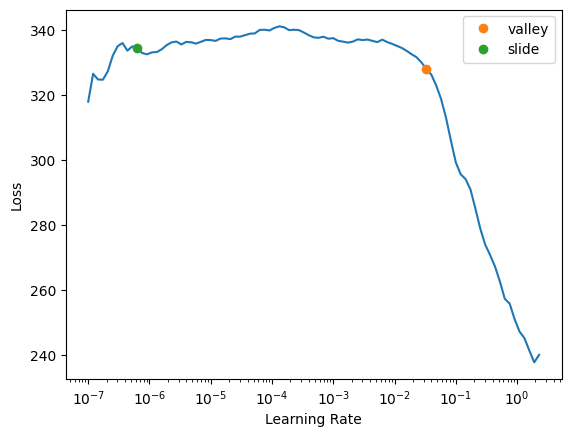

In [36]:
learn.lr_find(suggest_funcs=[valley, slide])

In [37]:
learn.fit_one_cycle(10, 0.002)

epoch,train_loss,valid_loss,mae,time
0,331.718292,320.649445,16.940538,00:02
1,291.547119,252.919922,15.003921,00:01
2,145.877518,67.883652,6.432228,00:01
3,47.334003,29.938957,3.525901,00:01
4,25.864594,28.555092,3.481845,00:01
5,21.788427,28.822622,3.531104,00:01
6,21.183561,28.500008,3.518812,00:01
7,20.709011,28.862623,3.547697,00:01
8,20.699558,28.225525,3.493829,00:01
9,20.554464,28.740355,3.527047,00:01


In [ ]:
# learn.recorder.plot_loss()
learn.show_results(max_n=10)

,year,month,day,weekday,hour,precip,temp,valeur,valeur_pred
0,2.048932,1.008442,-1.105812,-0.000228,0.361158,-0.169979,1.175227,27.363636,19.910059
1,2.048932,1.588322,-0.537719,1.500029,0.650084,-0.169979,-1.102265,14.363636,16.742748
2,2.634271,-0.731200,-1.446668,-1.500485,1.227936,-0.169979,-0.051115,20.909090,20.108850
3,2.048932,0.718502,0.257612,1.500029,-0.216695,-0.169979,0.382693,13.800000,10.032902
4,2.048932,-0.731200,1.280180,-0.500314,-0.794547,-0.169979,-0.042772,9.636364,17.905254
5,2.634271,-1.311080,-0.083244,-0.500314,-0.361158,-0.169979,-0.368129,14.545455,17.083231
6,2.048932,-0.151319,0.598468,-1.000399,0.072232,-0.169979,0.799817,19.400000,21.060369
7,2.048932,-1.311080,-0.651338,-0.000228,-0.216695,-0.169979,-0.393156,27.454546,18.337765
8,2.634271,-0.731200,0.257612,-1.000399,-1.661325,-0.169979,-0.026087,13.090909,17.990240
9,2.634271,-1.311080,0.712086,-0.500314,-1.083473,-0.169979,-1.394252,17.090910,18.372591


In [38]:
df_test = merged.loc[test_idxs]
test_dl = dls.test_dl(df_test)

In [39]:
preds, targets = learn.get_preds(dl=test_dl)

mae(preds, targets)

TensorBase(4.8788)

In [40]:
def mk_analysis_df(df, preds):
  return pd.DataFrame({'datetime': df['datetime'],
              'Actual': df['valeur'],
              'Predicted': preds })

analysis_df = mk_analysis_df(df_test, preds.flatten())

plot_preds(analysis_df)

interactive(children=(SelectionRangeSlider(description='Select Date Range', index=(0, 464), layout=Layout(widt…

# Random forest impl

_RandomForest doesn't seem to offer much better results than using deep learning for this dataset._

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import torch

m = RandomForestRegressor(n_jobs=-1, n_estimators=100,
        max_samples=10_000, max_features=0.5,
        min_samples_leaf=5, oob_score=True).fit(dls.train.xs, dls.train.y)
preds = m.predict(dls.valid.xs)
preds_tensor = torch.tensor(preds)

mae(preds_tensor, torch.tensor(dls.valid.y.values))

TensorBase(3.4242)

In [ ]:
df_test = merged.loc[test_idxs]
test_dl = dls.test_dl(df_test)

In [ ]:
preds = torch.tensor(m.predict(test_dl.xs))
mae(preds, torch.tensor(test_dl.y.values))

TensorBase(4.5673)

In [ ]:
def mk_analysis_df(df, preds):
  return pd.DataFrame({'datetime': df['datetime'],
              'Actual': df['valeur'],
              'Predicted': preds })

analysis_df = mk_analysis_df(df_test, preds)
analysis_df

,datetime,Actual,Predicted
61368,2023-01-01 00:00:00,21.818182,18.796947
61369,2023-01-01 01:00:00,15.909091,19.415405
61370,2023-01-01 02:00:00,12.363636,19.047986
61371,2023-01-01 03:00:00,10.909091,18.071020
61372,2023-01-01 04:00:00,11.363636,17.989505
...,...,...,...
72523,2024-04-09 19:00:00,22.818182,21.884124
72524,2024-04-09 20:00:00,21.272727,21.065109
72525,2024-04-09 21:00:00,20.727273,20.415613
72526,2024-04-09 22:00:00,19.727273,19.543265


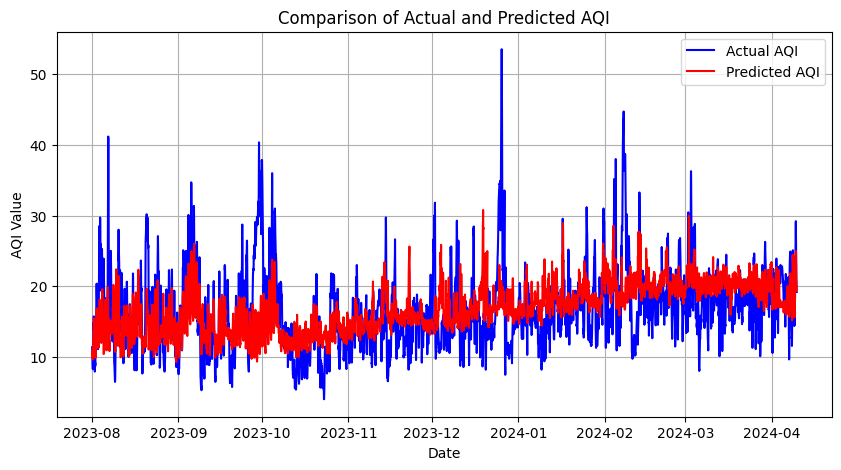

In [ ]:
plot_preds(analysis_df[analysis_df['datetime'] >= pd.Timestamp("2023-08-01")])